In [1]:
import pandasql as ps
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
# Offline mode
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [14]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)

In [15]:
full.shape

(26304, 10)

In [16]:
full.head()

,electricity,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,month,day,weekday,hour
timestamp,,,,,,,,,,
2016-01-01 00:00:00,17.7,3.8,2.4,1020.9,5,3.1,1,1,5,0
2016-01-01 01:00:00,37.1,3.7,2.4,1021.6,5,2.6,1,1,6,1
2016-01-01 02:00:00,37.8,2.6,1.9,1021.9,0,0.0,1,1,7,2
2016-01-01 03:00:00,35.1,2.0,1.2,1022.3,4,1.5,1,1,1,3
2016-01-01 04:00:00,27.5,2.3,1.8,1022.7,2,1.5,1,1,2,4


In [4]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = pd.DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in data.columns]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# load data
values = full.values
# check data is float
values = values.astype('float32')
# normalizing
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=full.columns)
# frame as supervised learning
n_hours = 12
n_features = 10
full = series_to_supervised(df_scaled, n_hours, 1)
print(full.shape)

(26292, 130)


In [12]:
full.head()

,electricity(t-12),air_temperature(t-12),dew_temperature(t-12),sea_level_pressure(t-12),wind_direction(t-12),wind_speed(t-12),month(t-12),day(t-12),weekday(t-12),hour(t-12),...,electricity(t),air_temperature(t),dew_temperature(t),sea_level_pressure(t),wind_direction(t),wind_speed(t),month(t),day(t),weekday(t),hour(t)
12,0.117219,0.223350,0.396040,0.665307,0.714286,0.512683,0.0,0.0,0.666667,0.000000,...,0.256954,0.304569,0.462046,0.640817,0.428571,0.569776,0.0,0.0,0.333333,0.521739
13,0.245695,0.220812,0.396040,0.674829,0.714286,0.498410,0.0,0.0,0.833333,0.043478,...,0.254967,0.309645,0.462046,0.620408,0.285714,0.586904,0.0,0.0,0.500000,0.565217
14,0.250331,0.192893,0.379538,0.678912,0.000000,0.424189,0.0,0.0,1.000000,0.086957,...,0.248344,0.314721,0.465347,0.601361,0.285714,0.569776,0.0,0.0,0.666667,0.608696
15,0.232450,0.177665,0.356436,0.684354,0.571429,0.467009,0.0,0.0,0.000000,0.130435,...,0.292715,0.317259,0.501650,0.583674,0.285714,0.629723,0.0,0.0,0.833333,0.652174
16,0.182119,0.185279,0.376238,0.689796,0.285714,0.467009,0.0,0.0,0.166667,0.173913,...,0.282781,0.319797,0.537954,0.568707,0.285714,0.586904,0.0,0.0,1.000000,0.695652


# 4. Definition and Fitting of the Model
Time Series Forecasting (LSTM)

We divide the data between train and test data. In total we have 3 years. We'll take for the training the first two years and the thir one leave it to the testing of the training. Thet is the same as taking the first 2/3 of the data to train and the remaining 1/3 to test.

### 4.1 Test and Training Sets

In [6]:
values = full.values
train_hours = int(2*full.shape[0]/3)
train = values[:train_hours, :]
test = values[train_hours:, :]

#Separate them into Variables and Targets
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17528, 12, 10) (17528,) (8764, 12, 10) (8764,)


### 4.2 Defining the Models

#### 4.2.1 Model 1

In [7]:
# define model
model_1 = Sequential()
#model_1.add(Bidirectional(LSTM(120, activation='relu', return_sequences = True), input_shape=(train_X.shape[1], train_X.shape[2])))
model_1.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model_1.add(Dense(13))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')

In [8]:
# fit model
history = model_1.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/100
244/244 [==============================] - 5s 14ms/step - loss: 0.0403 - val_loss: 0.0136
Epoch 2/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 3/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0083 - val_loss: 0.0189
Epoch 4/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0091 - val_loss: 0.0239
Epoch 5/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0089 - val_loss: 0.0253
Epoch 6/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0084 - val_loss: 0.0233
Epoch 7/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0071 - val_loss: 0.0221
Epoch 8/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0065 - val_loss: 0.0193
Epoch 9/100
244/244 [==============================] - 3s 11ms/step - loss: 0.0056 - val_loss: 0.0177
Epoch 10/100
244/244 [==============================] - 3s 11ms/step - loss: 0.004

Epoch 79/100
244/244 [==============================] - 3s 11ms/step - loss: 8.9268e-04 - val_loss: 0.0017
Epoch 80/100
244/244 [==============================] - 3s 11ms/step - loss: 9.5446e-04 - val_loss: 0.0016
Epoch 81/100
244/244 [==============================] - 3s 11ms/step - loss: 8.8129e-04 - val_loss: 0.0017
Epoch 82/100
244/244 [==============================] - 3s 11ms/step - loss: 8.1105e-04 - val_loss: 0.0017
Epoch 83/100
244/244 [==============================] - 3s 11ms/step - loss: 9.2156e-04 - val_loss: 0.0017
Epoch 84/100
244/244 [==============================] - 3s 11ms/step - loss: 8.6117e-04 - val_loss: 0.0017
Epoch 85/100
244/244 [==============================] - 3s 11ms/step - loss: 8.5528e-04 - val_loss: 0.0016
Epoch 86/100
244/244 [==============================] - 3s 11ms/step - loss: 8.4368e-04 - val_loss: 0.0016
Epoch 87/100
244/244 [==============================] - 3s 11ms/step - loss: 8.0011e-04 - val_loss: 0.0017
Epoch 88/100
244/244 [===============

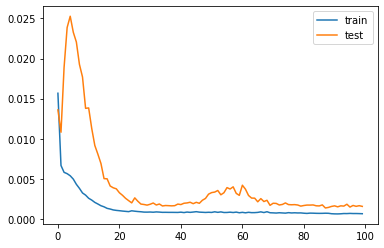

In [9]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

We create the test_input tensor to see how the network does when predicting.

In [10]:
# make a prediction
ypred = model_1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_ypred  = np.concatenate((ypred , test_X[:, -9:]), axis=1)
inv_ypred  = scaler.inverse_transform(inv_ypred )
inv_ypred  = inv_ypred [:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_ypred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.960


In [11]:
Predicted = go.Scatter(x=np.arange(len(inv_y)), y=inv_ypred, opacity = 1, name = 'Forecasted Value', line=dict(color='royalblue'), yaxis='y')
Actual = go.Scatter(x=np.arange(len(inv_y)), y=inv_y, opacity = 0.7, name = 'Actual Value', line=dict(color='lightblue'), yaxis='y')

layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show()